<a href="https://colab.research.google.com/github/ucheokechukwu/courses/blob/main/Pytorch_For_Deep_Learning/06_pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* https://www.learnpytorch.io/06_pytorch_transfer_learning/
* https://github.com/mrdbourke/pytorch-deep-learning/blob/main/06_pytorch_transfer_learning.ipynb


General refs:
https://github.com/IgorSusmelj/pytorch-styleguide#recommended-code-structure-for-training-your-model

Efficientnet:
https://arxiv.org/pdf/1905.11946.pdf

# 0. Setting up

In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu118
0.16.0+cu118


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# regular imports

# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 4036 (delta 1068), reused 1086 (delta 996), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.02 MiB | 19.17 MiB/s, done.
Resolving deltas: 100% (2361/2361), done.
Updating files: 100% (248/248), done.


# 1. Getting Data

In [4]:
import os
import zipfile
from pathlib import Path
import requests
# setup data path
data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi" # images from a subset of classes of Food101 Dataset

# if the image folder doesn't exist, we want to download the data and prepare it
if image_path.is_dir():
    print(f"{image_path} directory exists. skipping re-download")
else:
    print(f"did not find {image_path} directory. downloading...")
    image_path.mkdir(parents=True, exist_ok=True)
    # download the pizza, steak and sushi data
    with open(data_path/"pizza_steak_sushi.zip", 'wb') as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("downloading pizza_steak_sushi data...")
        f.write(request.content)
    # unzip the file we've downloaded
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", 'r') as zip_ref:
        print("unzipping pizza_steak_sushi data...")
        zip_ref.extractall(image_path)
    # delete the zip file
    os.remove(data_path/"pizza_steak_sushi.zip")

did not find data/pizza_steak_sushi directory. downloading...
downloading pizza_steak_sushi data...
unzipping pizza_steak_sushi data...


In [5]:
# set up directory path
train_dir = image_path/"train"
test_dir = image_path/"test"

# 2. Create Datasets and Dataloaders
We will use the `data_setup.py` script and the `create_dataloaders` function

When loading data, we have to think about how to transform the data. There are 2 ways to do this:

1. manually created transforms - user-defined, custom transforms
2. automatically created transforms - the transforms are defined by the model you want to use.

Important point: when using a **pretrained model**, it is important that the data is transformed in the same way that the data the model was trained on.

## 2.1 creating a transform for `torchvisions.models` (manual creation)

this contains pretrained models (models ready for transfer learning) in `torchvision`

```All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.
The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
You can use the following transform to normalize:```

In [10]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
manual_transforms = transforms.Compose([
    transforms.Resize((224,244)), # resize to h x of 224 2224

    transforms.ToTensor(), # get images in range [0,1]
    normalize, # put in the same distribution as the data the model was trained
])

from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir, test_dir,
    transform = manual_transforms,
    batch_size = 32,
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c6924d48e20>,
 ['pizza', 'steak', 'sushi'])

## 2.2 automatically created transforms

As of `torchvision v0.13+`, there is support for automatica data transformation based on the pretrained model weight that you're using

In [17]:
import torchvision
print(torchvision.__version__, "is the current version.")

# get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # Default is the best performing weight
display(weights)

# get the transformations
auto_transforms = weights.transforms() # it's that easy!
display(auto_transforms)

# now get the train_dataloader, test_dataloader
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir, test_dir,
    transform = auto_transforms,
    batch_size = 32
)
train_dataloader, test_dataloader, class_names

0.16.0+cu118 is the current version.


EfficientNet_B0_Weights.IMAGENET1K_V1

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

(<torch.utils.data.dataloader.DataLoader at 0x7c6910311870>,
 ['pizza', 'steak', 'sushi'])

* notice how the transform is the same as our manually created transformation

# 3. Getting a pretrained model

1. Pytorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub
4. Paperswithcode

### 3.1. Which pretrained model to use?
*Experiment, experiment, experiment*

The whole idea of transfer learning is to take an already well-performing model from a problem space similar to your own and customize it to your problem.

3 things to consider:
1. speed - how fast does it run?
2. size - how big is the model?
3. performance - how well does it run on the chosen problem?

Where does the model live? Is it on device? Or on the server? You want the fastest, smallest and best performing model.
the number of parameters is usually an indication of its size.

https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights


## 3.2 setting up a pretrained model

In [133]:
try:
    # OLD method of creating a pretrained model
    model = torchvision.models.efficientnet_b0(pretrained=True)
except Exception as e:
    try:
        # set up weights (repeating for compeleteness)
        weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
        model = torchvision.models.efficientnet_b0(weights=weights)
    except:
        # fix from https://github.com/pytorch/vision/issues/7744
        from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
        from torchvision.models._api import WeightsEnum
        from torch.hub import load_state_dict_from_url

        def get_state_dict(self, *args, **kwargs):
            kwargs.pop("check_hash")
            return load_state_dict_from_url(self.url, *args, **kwargs)
        WeightsEnum.get_state_dict = get_state_dict

        weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
        model = torchvision.models.efficientnet_b0(weights=weights)
        model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [134]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [135]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [136]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

Model is made of 3 parts:
`model.features` - extracts features
`model.avgpool` - **compresses** all the features into a single feature of size 1280
`model.classifier` - the classifier head turns the feature vector into an **output of feature probabilities** of 1000 (but we will change this to 3) classes.

Note that since we have 3 classes, we need to modify `model.classifier` `out_features` from **1000** to **3**.

In [137]:
from IPython.display import Image, clear_output



--2023-11-23 01:10:03--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-v2-effnetb0-model-print-out.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 669298 (654K) [image/png]
Saving to: ‘06-v2-effnetb0-model-print-out.png.7’

06-v2-effnetb0-mode 100%[===================>] 653.61K  --.-KB/s    in 0.03s   

2023-11-23 01:10:03 (19.1 MB/s) - ‘06-v2-effnetb0-model-print-out.png.7’ saved [669298/669298]



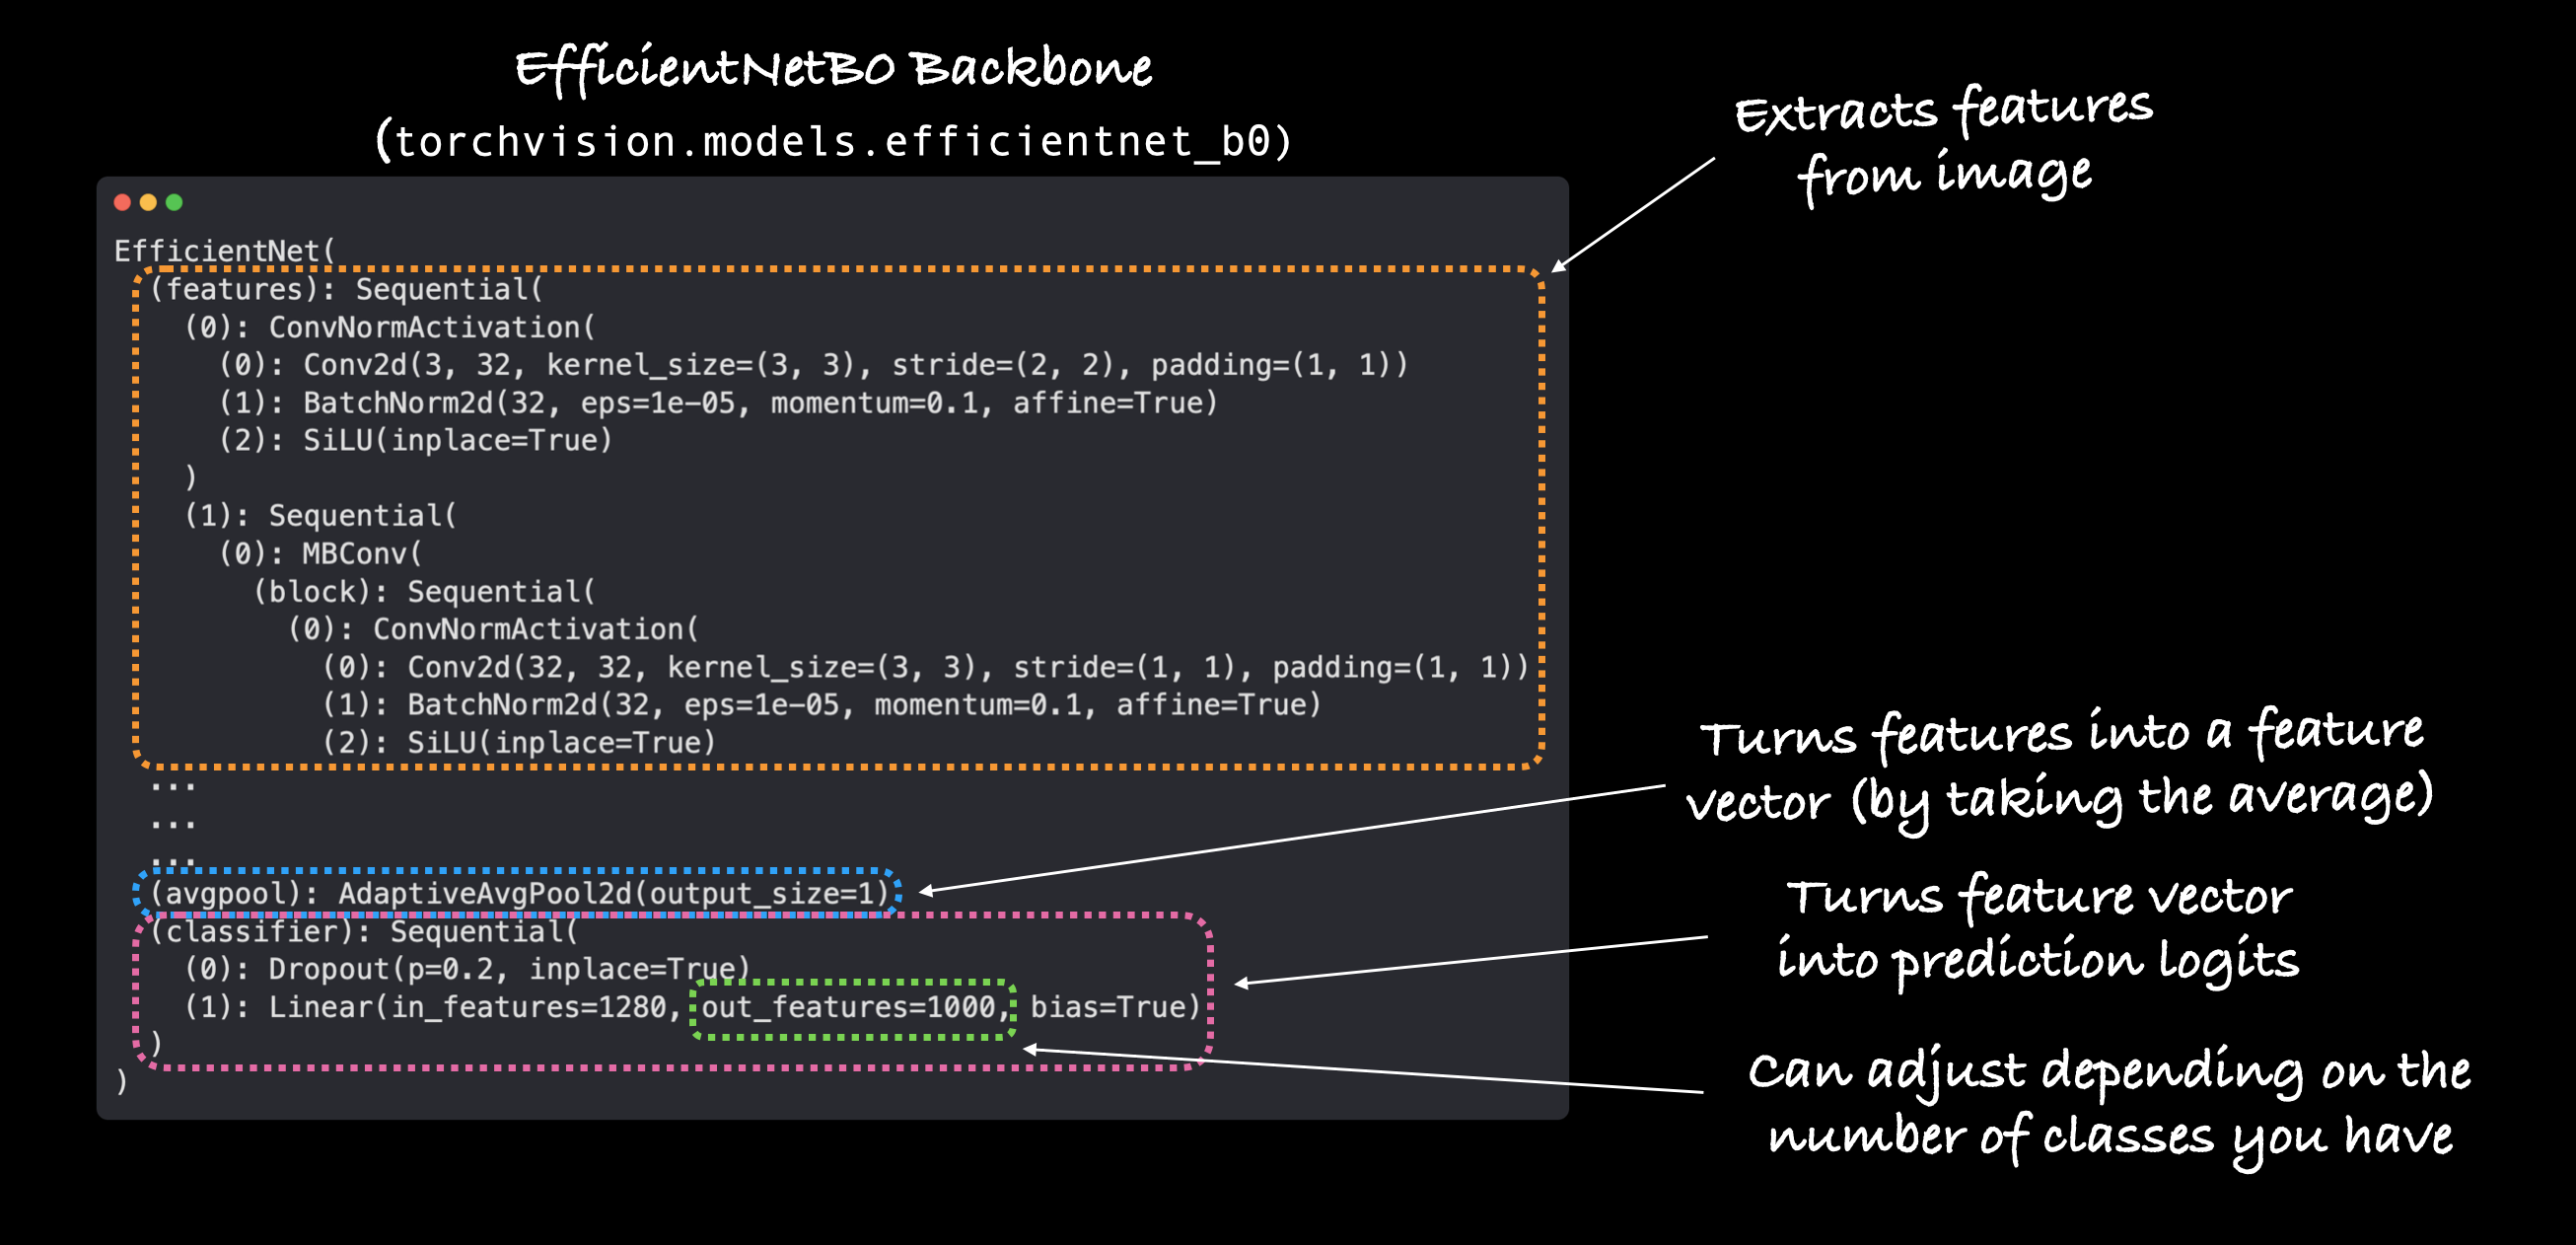

In [138]:
try:
    !wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-v2-effnetb0-model-print-out.png
    clear_output
    display(Image("06-v2-effnetb0-model-print-out.png"))
except:
    pass


--2023-11-23 01:10:03--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-torchinfo-summary-unfrozen-layers.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1246453 (1.2M) [image/png]
Saving to: ‘06-torchinfo-summary-unfrozen-layers.png.4’

06-torchinfo-summar 100%[===================>]   1.19M  --.-KB/s    in 0.05s   

2023-11-23 01:10:03 (25.7 MB/s) - ‘06-torchinfo-summary-unfrozen-layers.png.4’ saved [1246453/1246453]



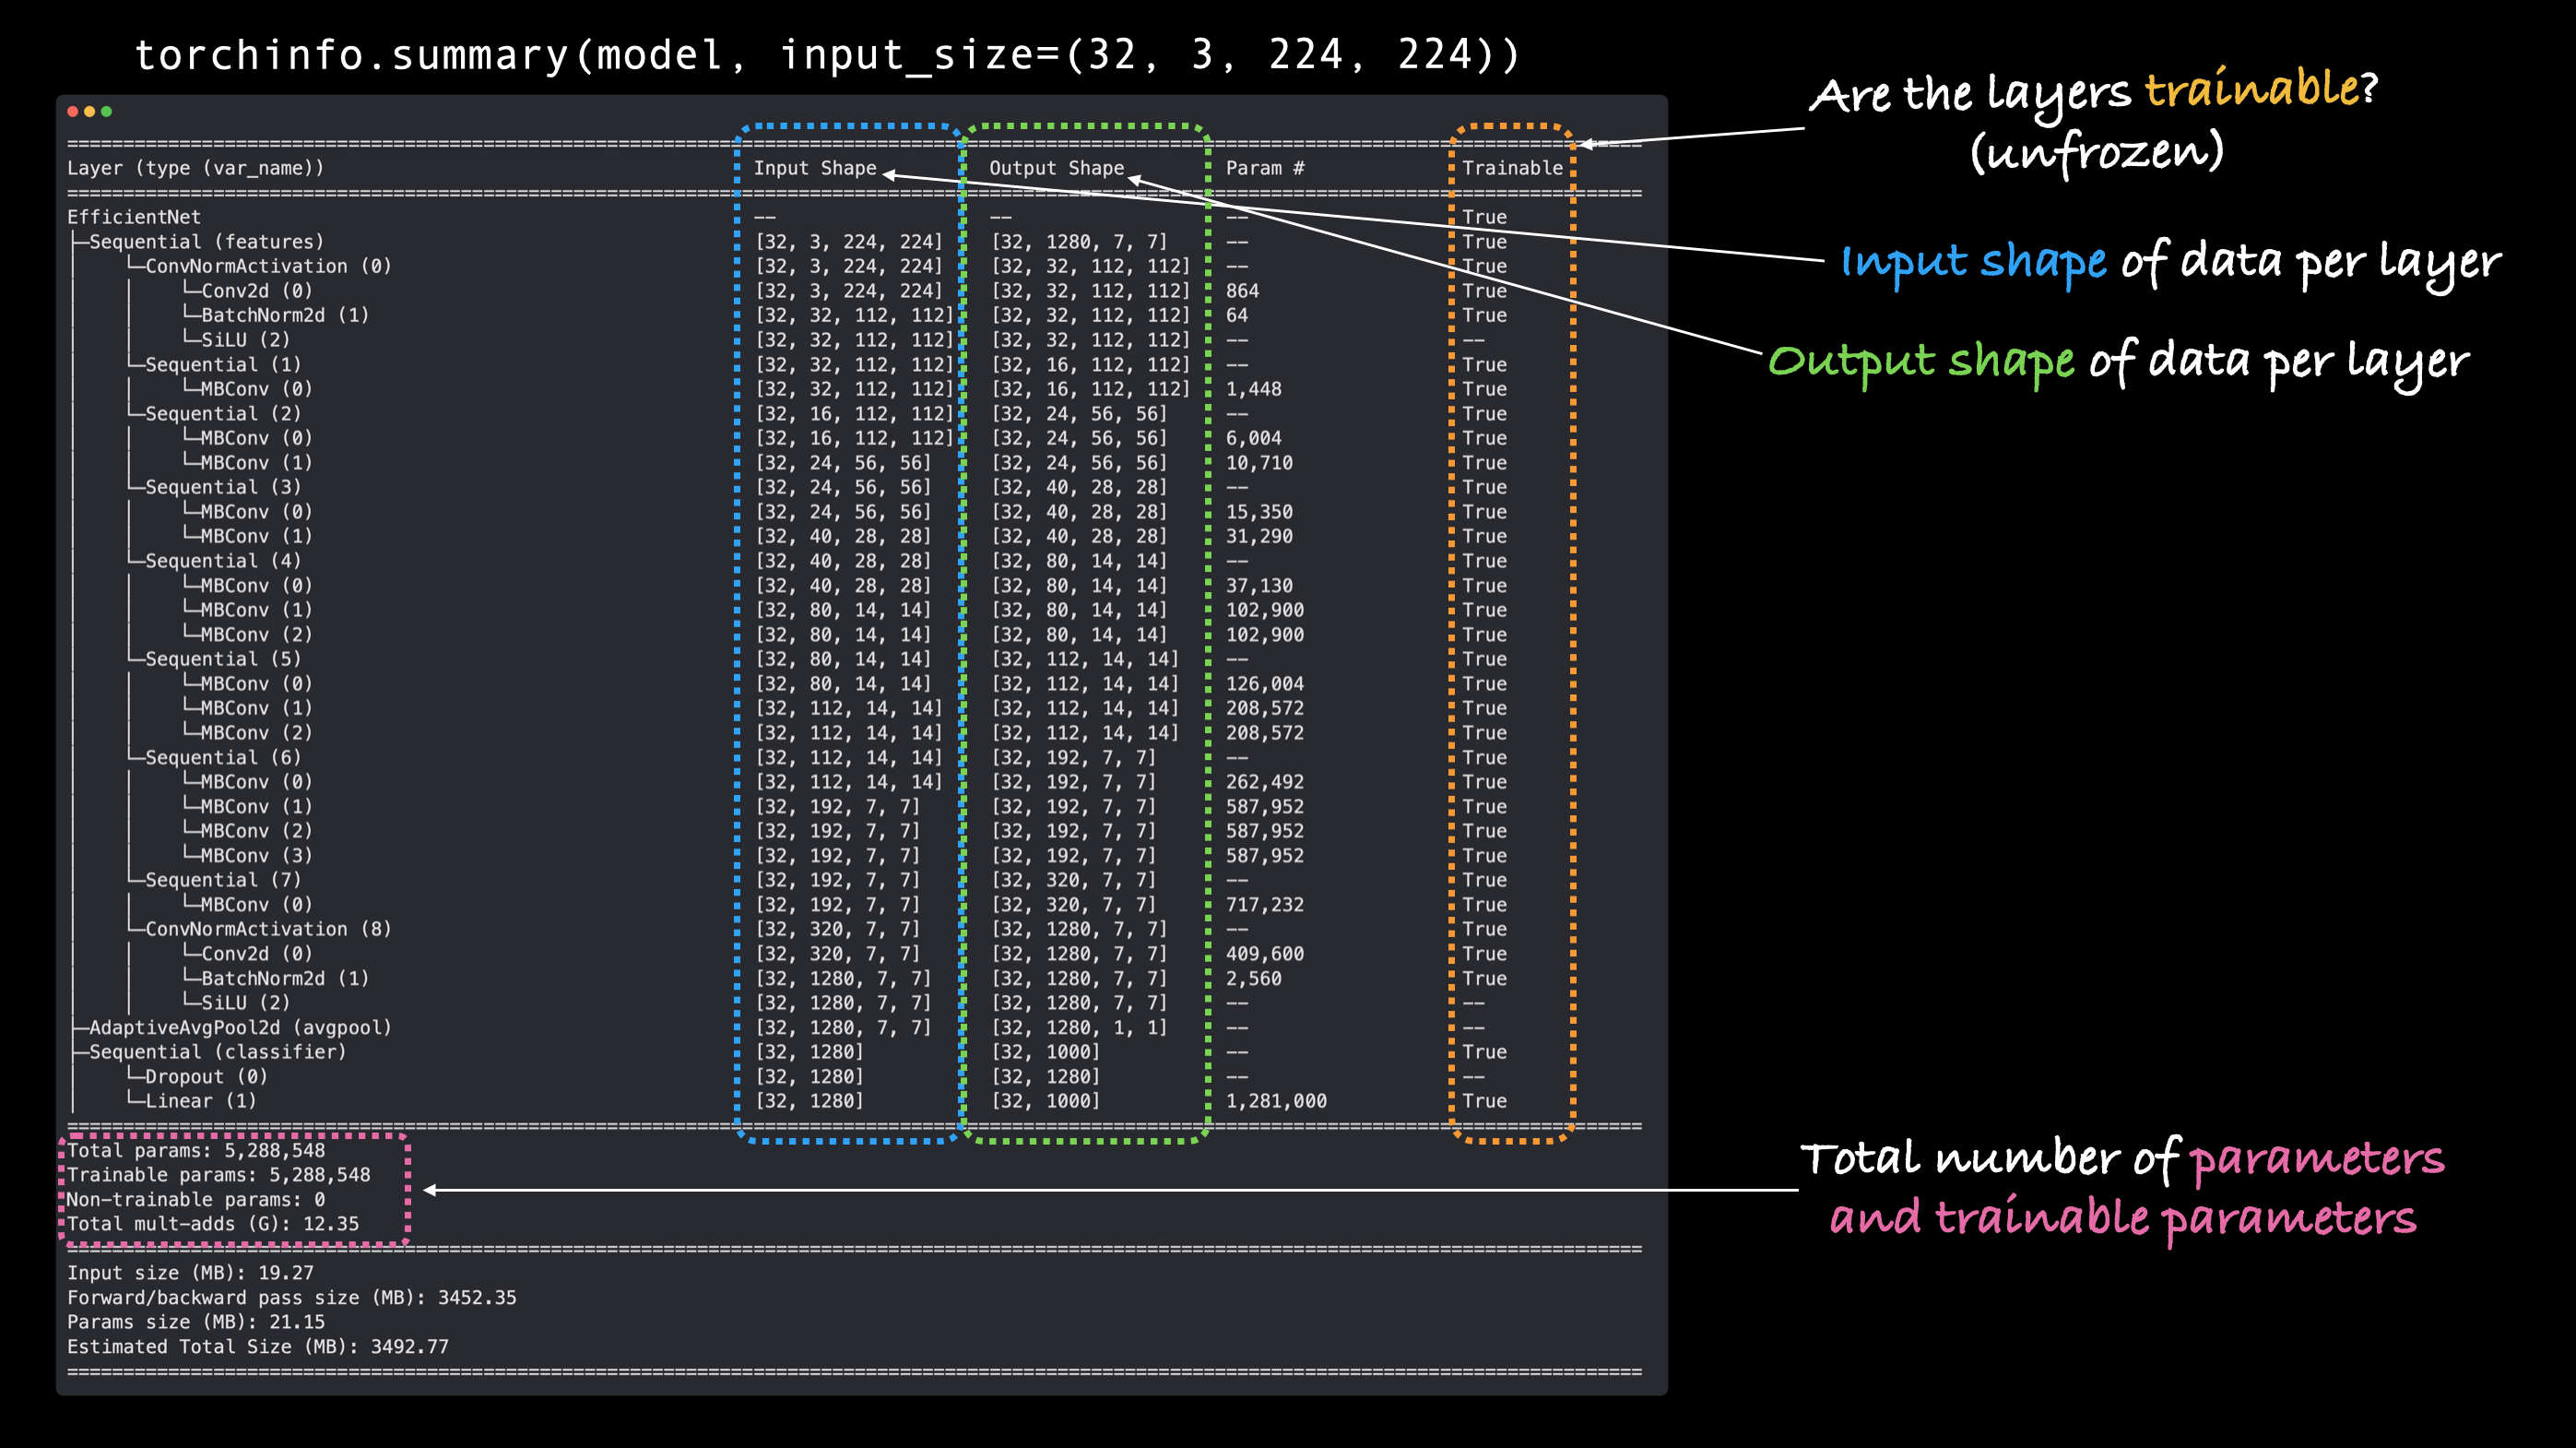

In [139]:
try:
    !wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-torchinfo-summary-unfrozen-layers.png
    display(Image("06-torchinfo-summary-unfrozen-layers.png"))
except:
    pass

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [140]:
from torchinfo import summary
summary(model=model,
        input_size=(1, 3, 224, 224), # our general input size: batch x channels x height x width
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base layer and changing the classifier head to suit our needs

this is the standard process method for feature extraction

In [141]:
# to freeze the base layers
for param in model.features.parameters():
    param.requires_grad = False
summary(model=model,
        input_size=(1, 3, 224, 224), # our general input size: batch x channels x height x width
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [142]:
# update the classifier head to 3 classes, not 1000 classes
torch.manual_seed(88)
torch.cuda.manual_seed(88)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=output_shape)
    ).to(device)

summary(model=model,
        input_size=(1, 3, 224, 224), # our general input size: batch x channels x height x width
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

# 4. Train Model

In [266]:
# define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# import train function
from going_modular.going_modular import engine

# set the manual seed
torch.manual_seed(88)
torch.cuda.manual_seed(88)

# start the timer
import time
start_timer = time.time()

# start the training and save results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=1,
                       device=device)
end_timer = time.time()
print(f"INFO Training time: {end_timer-start_timer:.2f} seconds")

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1700 | train_acc: 0.9844 | test_loss: 0.3544 | test_acc: 0.8561
INFO Training time: 2.33 seconds


# 5. Evaluate model by plotting loss curves

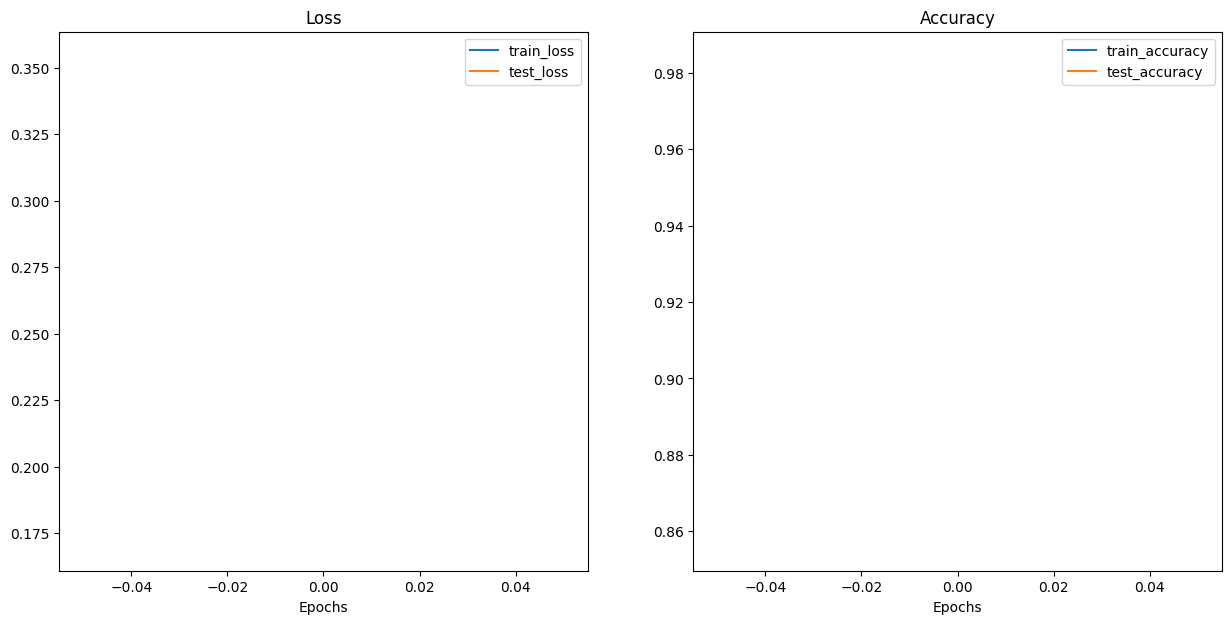

In [267]:
try:
    import helper_functions
except:
    !wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
    import helper_functions
helper_functions.plot_loss_curves(results)


# 6. Make Predictions on Images

*visualize visualize visualize*

We have to make the test/custom data in:
* the same **shape** as the data that the model was trained on
* in the same data **type** and
* on the same **device**
* same **`transform`**

To do all of this automagically, let's create a function called `pred_and_plot_image`:

1. Take in:

    i. trained model,

    ii. a list of class_names,

    iii. a filepath to a target image,

    iv. an image size,

    v. a transform, and

    vi. a target device.

2. Open the image with `PIL`
3. Create a `transform`
4. make sure model and data are on the target device
5. put `model.eval()` mode on for inference (will turn off nn.dropout
6. transform the target image and make sure its dimensionality is suitable for the model (batch size of 1)
7. forward pass to make a prediction
8. convert the model's output logits to prediction probabilities (`torch.softmax`)
9. convert prediction probabilities to prediction labels (`torch.argmax`)
10. plot the image with matplotlib and set the title to the prediction label from 9, and prediction probability from step 8.

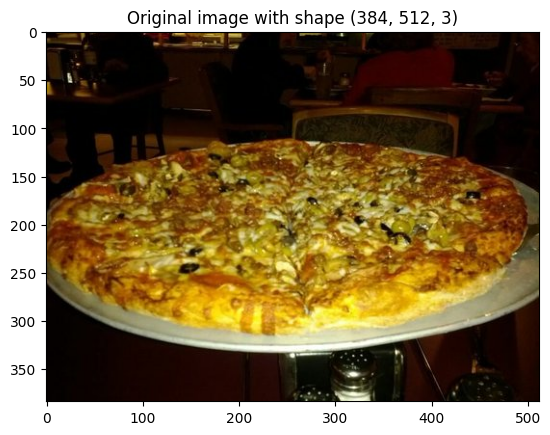

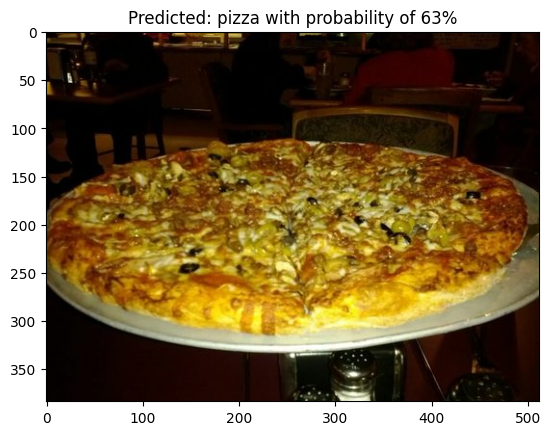

In [240]:
from typing import List, Tuple
from torchvision import transforms
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

def pred_and_plot_image(
                        model: nn.Module,
                        filepath: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms=None,
                        device: torch.device = device):
    ### takes an image filepath and tests out the model's performance with it"


    # 2. open the image with PIL

    im = Image.open(filepath)
    plt.imshow(im)
    plt.title(f"Original image with shape {np.array(im).shape}")
    plt.show()

    # 3. create a transform
    if transform is not None:
        transform = transform
    else:
        transform = transforms.Compose(
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        )


    # 4. put on the target device
    image_transformed = transform(im).to(device)
    model.to(device)

    # 5. turn on inference and eval mode
    model.eval()
    with torch.inference_mode():

        # 6. batchify the image
        image_transformed = image_transformed.unsqueeze(dim=0)
        # 7. forward pass
        logits = model(image_transformed)

    # 8. get the logits (we don't need softmax, we can skip to argmax but for completeness)
    logits = torch.softmax(logits, dim=-1)
    pred_probabilities = logits.argmax(dim=-1).item()

    # 9. get the labels
    pred_labels = class_names[pred_probabilities]


    # 10. visualize with prediction
    prediction = logits.squeeze()[pred_probabilities].item()
    plt.imshow(im)
    plt.title(f"Predicted: {pred_labels} with probability of {prediction:.0%}")
    plt.show()

filepath = "/content/data/pizza_steak_sushi/test/pizza/1152100.jpg"
pred_and_plot_image(model, filepath,
                    class_names=class_names,
                    transform = auto_transforms)


In [219]:
class_names

['pizza', 'steak', 'sushi']

[PosixPath('data/pizza_steak_sushi/test/sushi/175783.jpg'), PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'), PosixPath('data/pizza_steak_sushi/test/sushi/1245193.jpg')]


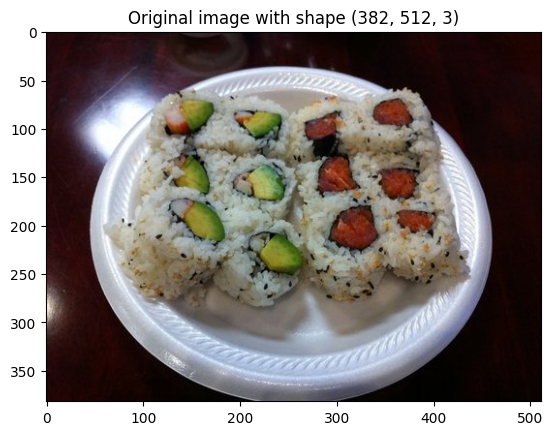

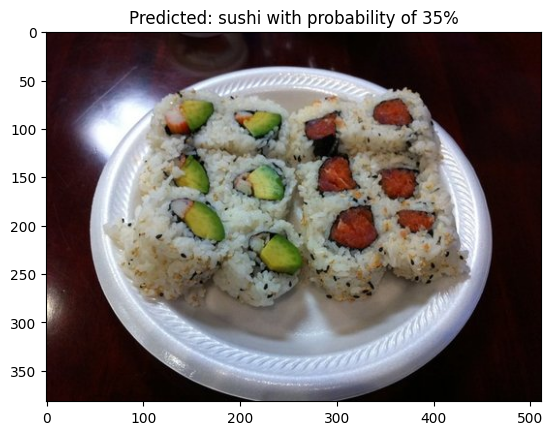

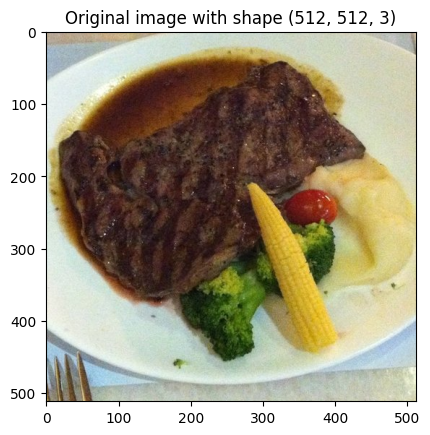

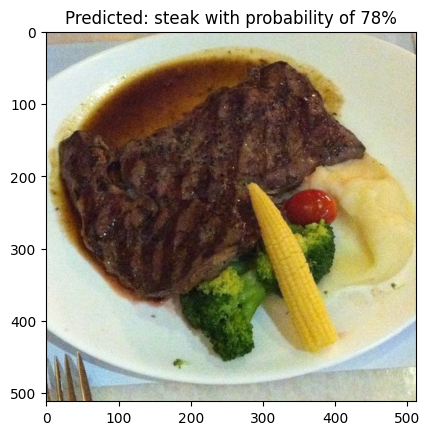

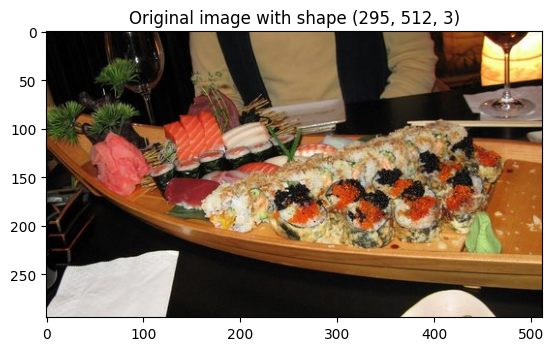

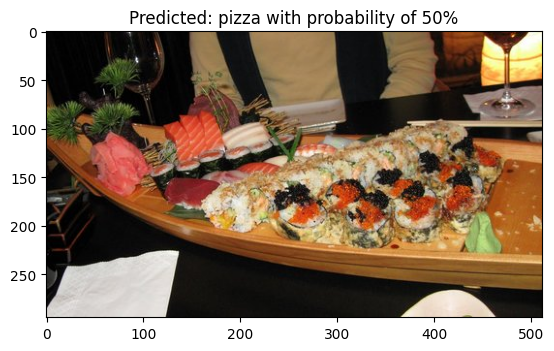

In [256]:
import random

num_of_images_to_plot = 3

random_file_path = list(Path(test_dir).glob("*/*.jpg"))
random_file_path = random.sample(population=random_file_path, k=num_of_images_to_plot)

print(random_file_path)
for filepath in random_file_path:
    pred_and_plot_image(model,
                        filepath = filepath,
                        class_names=class_names,
                        transform = auto_transforms)

## Making prediction on a custom image

data/04-pizza-dad.jpeg already exists, skipping download.


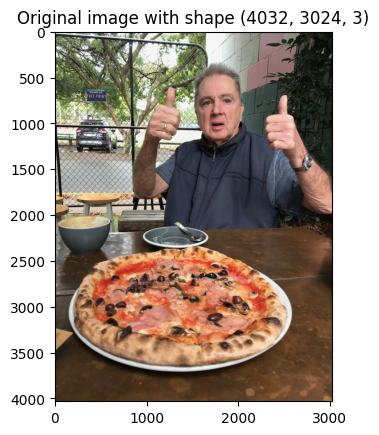

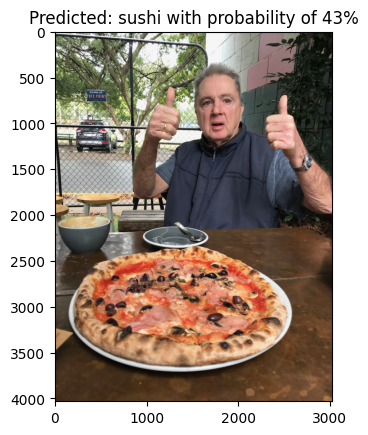

In [268]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    filepath=custom_image_path,
                    class_names=class_names,
                    transform = auto_transforms)